# London Cycling Model

### London data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap
# Ignore copy warning
pd.options.mode.chained_assignment = None 

In [2]:
# Load London data 
inner = pd.read_csv('London/inner.csv')
outer = pd.read_csv('London/Outer London.csv')
central = pd.read_csv('London/central.csv')

In [3]:
# Add columns 
central['area'] = 'Central'
inner['area'] = 'Inner'
outer['area'] = 'Outer'
central['Survey wave (year)'] = [central['Survey wave (calendar quarter)'][i].split()[0] 
                                 for i in range(central.shape[0])]

In [4]:
# Join London dataframes 
london = pd.concat([central, inner, outer]).reset_index(drop=True)

In [5]:
# Get day of week and date from survey date column

london['Survey date'].replace(' ', np.NaN, inplace=True)
london['Survey date'] = london['Survey date'].fillna(', ')

london['days'] = [london['Survey date'][i].split(', ')[0] for i in range(london.shape[0])]
london['date'] = [london['Survey date'][i].split(', ')[1] for i in range(london.shape[0])]

london['Survey date'].replace(', ', np.NaN, inplace=True)

day_mapping = {
    'lun' : 'Monday',
    'mar' : 'Tuesday',
    'mer' : 'Wednesday',
    'jeu' : 'Thursday',
    'ven' : 'Friday',
    'sam' : 'Saturday',
    'dim' : 'Sunday',
    '' : np.NaN
}

london['day_of_week'] = london['days'].map(day_mapping)
london.date.replace('', np.nan, inplace=True)
london.drop(['Survey date', 'days'], axis=1, inplace=True)

In [6]:
# Drop columns less important in analysis 
london = london.drop(['Survey wave (calendar quarter)', 'Equivalent financial quarter', 'Location', 
                      'Time', 'Direction', 'Start minute', 'Number of unknown cycles'], axis=1)

In [7]:
# Rename columns 
london.rename(columns={'Site ID':'site', 'Weather':'weather', 'Period':'period', 'Start hour':'hour', 
                       'Number of private cycles':'private', 'Number of cycle hire bikes':'hired', 
                       'Total cycles':'total_cycles', 'Survey wave (year)':'year', 'Number of male cycles':'male',
                       'Number of female cycles':'female'}, inplace=True)

In [8]:
# Standardise weather 
london.weather = london.weather.str.lower()
london.weather = london.weather.fillna('')

wet_list = ['wet', 'rain', 'drizz', 'shower', 'damp', 'mizzle', 'down pour', 'deluge', 'spit', ' shr']
good_list = ['sun', 'fine', 'fair', 'warm', 'hot', 'good', 'mild', 'clear', 'bright']
poor_list = ['cloud', 'overcast', 'cold', 'cool', 'wind', 'dull', 'dark', 'chill', 'hazy', 'foggy', 
             'blustery', 'mist', 'snow', 'hail', 'sleet', 'storm', 'thunder']

weather_cat = []
for weather_text in london.weather:
    if any(word in weather_text for word in wet_list) and 'dry' in weather_text:
        weather_cat.append('mixed')
    elif 'dry' in weather_text:
        weather_cat.append('dry')
    elif any(word in weather_text for word in wet_list):
        weather_cat.append('wet')
    elif (any(word in weather_text for word in good_list) and any(word in weather_text for word in poor_list)) or weather_text == 'mixed':
        weather_cat.append('mixed')       
    elif any(word in weather_text for word in good_list):
        weather_cat.append('good')        
    elif any(word in weather_text for word in poor_list):
        weather_cat.append('poor')       
    else:
        weather_cat.append(np.nan)    
        
london['weather'] = weather_cat

In [9]:
# Convert date data 
london['date'] = pd.to_datetime(london['date'], errors='coerce')
london['month'] = london['date'].dt.month

# Convert year from object to integer type
london = london.astype({'year':'int'})

### Differences in cycling 

Text(0.5, 0, 'Number of cyclists')

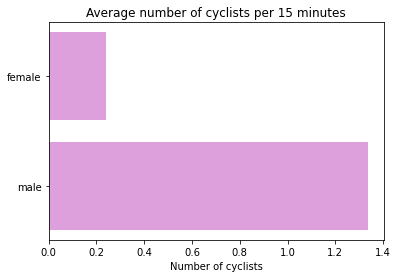

In [10]:
# Male vs female cyclists (Outer London)
sex_df = pd.DataFrame(london[['male', 'female']].mean(), columns=['mean']).reset_index()
plt.barh(sex_df['index'], sex_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

Text(0.5, 0, 'Number of cyclists')

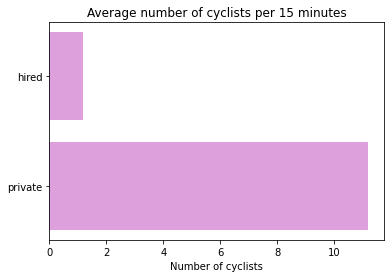

In [11]:
# Private vs hired cycles (Inner and Central London)
private_df = pd.DataFrame(london[['private', 'hired']].mean(), columns=['mean']).reset_index()
plt.barh(private_df['index'], private_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

### Infrastructure data 

In [35]:
# Get borough of each London site 
sites = pd.read_excel('London/Biking sites.xlsx')[[
    'UnqID', 'Borough']].rename(columns={'UnqID':'site', 'Borough':'borough'})
london = london.merge(sites, how='left', on='site')

# Group london data by borough
london_boroughs = london.groupby(['borough']).mean()[['total_cycles']].reset_index()

In [48]:
# Get borough infrastructure data 
borough_df = pd.read_csv('london_infrastructure/borough_infrastructure.csv')

In [49]:
# Merge borough data together
borough_df = pd.merge(london_boroughs, borough_df, how='outer', on='borough')

# Correlations between mean cyclists and surveyed infrastructure 
for col in ['cycle_parking_count', 'restricted_point_count', 'signage_count', 'signal_count', 'traffic_calming_count', 
            'crossing_count', 'advanced_stop_line_count', 'restricted_route_count', 'cycle_lane_track_count']:
    print(col, '\n', np.corrcoef(borough_df['total_cycles'], borough_df[col]), '\n')

cycle_parking_count 
 [[1.         0.58849277]
 [0.58849277 1.        ]] 

restricted_point_count 
 [[ 1.         -0.13278599]
 [-0.13278599  1.        ]] 

signage_count 
 [[1.        0.0227193]
 [0.0227193 1.       ]] 

signal_count 
 [[1.         0.75412353]
 [0.75412353 1.        ]] 

traffic_calming_count 
 [[ 1.         -0.00523325]
 [-0.00523325  1.        ]] 

crossing_count 
 [[ 1.         -0.44456452]
 [-0.44456452  1.        ]] 

advanced_stop_line_count 
 [[1.         0.62821962]
 [0.62821962 1.        ]] 

restricted_route_count 
 [[1.         0.19811602]
 [0.19811602 1.        ]] 

cycle_lane_track_count 
 [[ 1.         -0.46381071]
 [-0.46381071  1.        ]] 



### Modelling 

In [51]:
# Load distance to infrastructure data 
updated_sites = pd.read_csv('London/updated_sites.csv')

In [54]:
# Add infrastructure data to dataframe 

distance_data = updated_sites[['UnqID', 'closest_restricted_point', 'restricted_point_count_100m',
 'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 'signal_count_1000m',
 'closest_crossing', 'crossing_count_100m', 'crossing_count_1000m', 'closest_advanced_stop_line',
 'advanced_stop_line_count_100m', 'advanced_stop_line_count_1000m', 'closest_restricted_route',
 'restricted_route_count_100m', 'restricted_route_count_1000m', 'closest_cycle_parking',
 'cycle_parking_count_100m', 'cycle_parking_count_1000m']].rename(columns={'UnqID':'site'})

london = london.merge(distance_data, how='left', on='site')

In [56]:
# Select features for model 
london_model = london[['year', 'month', 'day_of_week', 'period', 'hour', 'area', 'borough', 'weather', 
                       'total_cycles', 'closest_restricted_point', 'restricted_point_count_100m', 
                       'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 
                       'signal_count_1000m', 'closest_crossing', 'crossing_count_100m', 
                       'crossing_count_1000m', 'closest_advanced_stop_line', 'advanced_stop_line_count_100m', 
                       'advanced_stop_line_count_1000m', 'closest_restricted_route', 
                       'restricted_route_count_100m', 'restricted_route_count_1000m', 'closest_cycle_parking', 
                       'cycle_parking_count_100m', 'cycle_parking_count_1000m']]

# Exclude rows with null values 
london_model = london_model.dropna()

# ~1.6% of total rows dropped
(london_model.shape[0]/london.shape[0])*100

98.41891796508082

In [57]:
# Change month column from float to int
london_model.month = london_model.month.astype(int)

# Set categorical categories as category 
cat_cols = ['month', 'day_of_week', 'period', 'area', 'borough', 'weather']
for col in cat_cols:
    london_model[col] = london_model[col].astype('category')
    london_model[col] = london_model[col].cat.codes

# Record categorical columns 
cat_index = []
for col in cat_cols:
    cat_index.append(london_model.columns.get_loc(col))

In [59]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=200)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

0:	learn: -1.5848899	test: -1.5842957	best: -1.5842957 (0)	total: 2.57s	remaining: 8m 30s
1:	learn: -3.8536743	test: -3.8537403	best: -3.8537403 (1)	total: 4.86s	remaining: 8m 1s
2:	learn: -5.9271959	test: -5.9267463	best: -5.9267463 (2)	total: 7.24s	remaining: 7m 55s
3:	learn: -7.7070273	test: -7.7055966	best: -7.7055966 (3)	total: 9.62s	remaining: 7m 51s
4:	learn: -9.2646497	test: -9.2631164	best: -9.2631164 (4)	total: 12.1s	remaining: 7m 53s
5:	learn: -10.6846824	test: -10.6822848	best: -10.6822848 (5)	total: 14.6s	remaining: 7m 51s
6:	learn: -11.8958411	test: -11.8934435	best: -11.8934435 (6)	total: 16.9s	remaining: 7m 44s
7:	learn: -12.9432422	test: -12.9401769	best: -12.9401769 (7)	total: 19.1s	remaining: 7m 38s
8:	learn: -13.8336246	test: -13.8312375	best: -13.8312375 (8)	total: 21s	remaining: 7m 26s
9:	learn: -14.6016967	test: -14.5984002	best: -14.5984002 (9)	total: 23.6s	remaining: 7m 28s
10:	learn: -15.2758095	test: -15.2709914	best: -15.2709914 (10)	total: 26s	remaining: 7m

87:	learn: -20.4291686	test: -20.3973992	best: -20.3973992 (87)	total: 3m 18s	remaining: 4m 12s
88:	learn: -20.4324044	test: -20.3998444	best: -20.3998444 (88)	total: 3m 20s	remaining: 4m 10s
89:	learn: -20.4364470	test: -20.4035138	best: -20.4035138 (89)	total: 3m 22s	remaining: 4m 7s
90:	learn: -20.4482667	test: -20.4153865	best: -20.4153865 (90)	total: 3m 24s	remaining: 4m 5s
91:	learn: -20.4522690	test: -20.4189681	best: -20.4189681 (91)	total: 3m 27s	remaining: 4m 3s
92:	learn: -20.4619110	test: -20.4282610	best: -20.4282610 (92)	total: 3m 29s	remaining: 4m
93:	learn: -20.4655812	test: -20.4317805	best: -20.4317805 (93)	total: 3m 31s	remaining: 3m 57s
94:	learn: -20.4686487	test: -20.4347496	best: -20.4347496 (94)	total: 3m 32s	remaining: 3m 55s
95:	learn: -20.4771449	test: -20.4430944	best: -20.4430944 (95)	total: 3m 35s	remaining: 3m 52s
96:	learn: -20.4836073	test: -20.4491291	best: -20.4491291 (96)	total: 3m 37s	remaining: 3m 50s
97:	learn: -20.4942279	test: -20.4592999	best: 

172:	learn: -20.8651360	test: -20.8101857	best: -20.8101857 (172)	total: 6m 21s	remaining: 59.5s
173:	learn: -20.8658567	test: -20.8106494	best: -20.8106494 (173)	total: 6m 23s	remaining: 57.3s
174:	learn: -20.8699962	test: -20.8145117	best: -20.8145117 (174)	total: 6m 25s	remaining: 55s
175:	learn: -20.8707316	test: -20.8147277	best: -20.8147277 (175)	total: 6m 27s	remaining: 52.8s
176:	learn: -20.8722591	test: -20.8162052	best: -20.8162052 (176)	total: 6m 29s	remaining: 50.6s
177:	learn: -20.8736216	test: -20.8167836	best: -20.8167836 (177)	total: 6m 31s	remaining: 48.4s
178:	learn: -20.8754312	test: -20.8184229	best: -20.8184229 (178)	total: 6m 33s	remaining: 46.2s
179:	learn: -20.8787814	test: -20.8214731	best: -20.8214731 (179)	total: 6m 35s	remaining: 44s
180:	learn: -20.8814044	test: -20.8241816	best: -20.8241816 (180)	total: 6m 38s	remaining: 41.8s
181:	learn: -20.8829356	test: -20.8254108	best: -20.8254108 (181)	total: 6m 40s	remaining: 39.6s
182:	learn: -20.8851031	test: -20.

In [61]:
# Model performance 
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')

RMSE: 12.766966332122099
R Squared: 0.6462804427527041


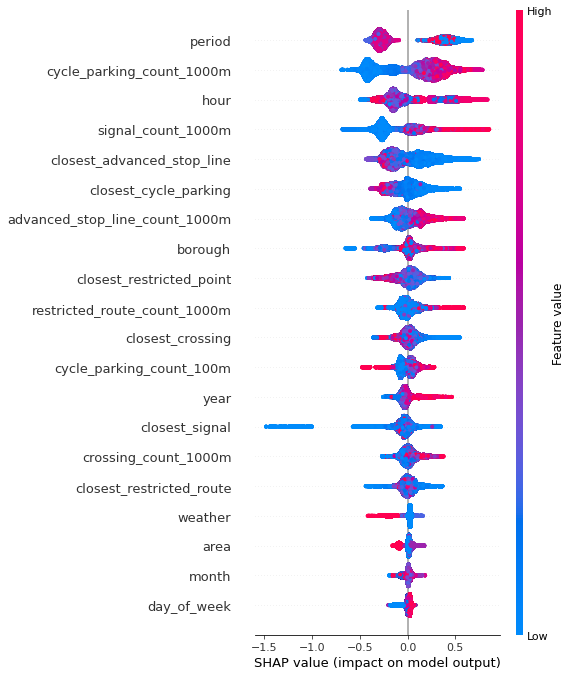

In [63]:
# Feature importance with infrastructure data 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [64]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=10000)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

0:	learn: -1.5848899	test: -1.5842957	best: -1.5842957 (0)	total: 2.64s	remaining: 7h 20m 36s
1:	learn: -3.8536743	test: -3.8537403	best: -3.8537403 (1)	total: 4.89s	remaining: 6h 47m 19s
2:	learn: -5.9271959	test: -5.9267463	best: -5.9267463 (2)	total: 7.95s	remaining: 7h 21m 20s
3:	learn: -7.7070273	test: -7.7055966	best: -7.7055966 (3)	total: 10.4s	remaining: 7h 14m 40s
4:	learn: -9.2646497	test: -9.2631164	best: -9.2631164 (4)	total: 13.1s	remaining: 7h 15m 3s
5:	learn: -10.6846824	test: -10.6822848	best: -10.6822848 (5)	total: 15.6s	remaining: 7h 12m 8s
6:	learn: -11.8958411	test: -11.8934435	best: -11.8934435 (6)	total: 17.9s	remaining: 7h 6m 54s
7:	learn: -12.9432422	test: -12.9401769	best: -12.9401769 (7)	total: 20.1s	remaining: 6h 57m 31s
8:	learn: -13.8336246	test: -13.8312375	best: -13.8312375 (8)	total: 22.2s	remaining: 6h 50m 47s
9:	learn: -14.6016967	test: -14.5984002	best: -14.5984002 (9)	total: 24.7s	remaining: 6h 50m 42s
10:	learn: -15.2758095	test: -15.2709914	best: -

84:	learn: -20.3984754	test: -20.3673927	best: -20.3673927 (84)	total: 3m 6s	remaining: 6h 3m 24s
85:	learn: -20.4028650	test: -20.3714318	best: -20.3714318 (85)	total: 3m 8s	remaining: 6h 3m 4s
86:	learn: -20.4116952	test: -20.3799838	best: -20.3799838 (86)	total: 3m 10s	remaining: 6h 2m 33s
87:	learn: -20.4291686	test: -20.3973992	best: -20.3973992 (87)	total: 3m 12s	remaining: 6h 2m 15s
88:	learn: -20.4324044	test: -20.3998444	best: -20.3998444 (88)	total: 3m 14s	remaining: 6h 1m 46s
89:	learn: -20.4364470	test: -20.4035138	best: -20.4035138 (89)	total: 3m 17s	remaining: 6h 1m 36s
90:	learn: -20.4482667	test: -20.4153865	best: -20.4153865 (90)	total: 3m 19s	remaining: 6h 1m 13s
91:	learn: -20.4522690	test: -20.4189681	best: -20.4189681 (91)	total: 3m 21s	remaining: 6h 58s
92:	learn: -20.4619110	test: -20.4282610	best: -20.4282610 (92)	total: 3m 23s	remaining: 6h 28s
93:	learn: -20.4655812	test: -20.4317805	best: -20.4317805 (93)	total: 3m 25s	remaining: 6h 16s
94:	learn: -20.4686487

166:	learn: -20.8472756	test: -20.7936846	best: -20.7936846 (166)	total: 6m	remaining: 5h 54m 11s
167:	learn: -20.8482117	test: -20.7939782	best: -20.7939782 (167)	total: 6m 3s	remaining: 5h 54m 25s
168:	learn: -20.8526646	test: -20.7984025	best: -20.7984025 (168)	total: 6m 5s	remaining: 5h 54m 22s
169:	learn: -20.8599671	test: -20.8057527	best: -20.8057527 (169)	total: 6m 7s	remaining: 5h 54m 8s
170:	learn: -20.8624478	test: -20.8082378	best: -20.8082378 (170)	total: 6m 9s	remaining: 5h 54m 4s
171:	learn: -20.8639264	test: -20.8093205	best: -20.8093205 (171)	total: 6m 11s	remaining: 5h 53m 53s
172:	learn: -20.8651360	test: -20.8101857	best: -20.8101857 (172)	total: 6m 13s	remaining: 5h 53m 52s
173:	learn: -20.8658567	test: -20.8106494	best: -20.8106494 (173)	total: 6m 16s	remaining: 5h 54m 12s
174:	learn: -20.8699962	test: -20.8145117	best: -20.8145117 (174)	total: 6m 18s	remaining: 5h 54m 13s
175:	learn: -20.8707316	test: -20.8147277	best: -20.8147277 (175)	total: 6m 20s	remaining: 5

247:	learn: -20.9984664	test: -20.9231551	best: -20.9231551 (247)	total: 9m 6s	remaining: 5h 58m 13s
248:	learn: -20.9987368	test: -20.9231763	best: -20.9231763 (248)	total: 9m 8s	remaining: 5h 58m 7s
249:	learn: -21.0010717	test: -20.9253111	best: -20.9253111 (249)	total: 9m 11s	remaining: 5h 58m 15s
250:	learn: -21.0020302	test: -20.9256464	best: -20.9256464 (250)	total: 9m 13s	remaining: 5h 58m 11s
251:	learn: -21.0031368	test: -20.9265942	best: -20.9265942 (251)	total: 9m 15s	remaining: 5h 58m 9s
252:	learn: -21.0037021	test: -20.9268463	best: -20.9268463 (252)	total: 9m 17s	remaining: 5h 58m 9s
253:	learn: -21.0039290	test: -20.9269352	best: -20.9269352 (253)	total: 9m 19s	remaining: 5h 57m 58s
254:	learn: -21.0047926	test: -20.9273929	best: -20.9273929 (254)	total: 9m 21s	remaining: 5h 57m 55s
255:	learn: -21.0050923	test: -20.9275046	best: -20.9275046 (255)	total: 9m 23s	remaining: 5h 57m 46s
256:	learn: -21.0082163	test: -20.9304614	best: -20.9304614 (256)	total: 9m 26s	remaini

327:	learn: -21.0698651	test: -20.9739701	best: -20.9739701 (327)	total: 12m 7s	remaining: 5h 57m 28s
328:	learn: -21.0703138	test: -20.9741884	best: -20.9741884 (328)	total: 12m 9s	remaining: 5h 57m 30s
329:	learn: -21.0730849	test: -20.9770084	best: -20.9770084 (329)	total: 12m 11s	remaining: 5h 57m 29s
330:	learn: -21.0734555	test: -20.9771507	best: -20.9771507 (330)	total: 12m 14s	remaining: 5h 57m 24s
331:	learn: -21.0738669	test: -20.9772805	best: -20.9772805 (331)	total: 12m 16s	remaining: 5h 57m 28s
332:	learn: -21.0747153	test: -20.9778957	best: -20.9778957 (332)	total: 12m 18s	remaining: 5h 57m 23s
333:	learn: -21.0752937	test: -20.9780764	best: -20.9780764 (333)	total: 12m 20s	remaining: 5h 57m 22s
334:	learn: -21.0764984	test: -20.9786002	best: -20.9786002 (334)	total: 12m 23s	remaining: 5h 57m 16s
335:	learn: -21.0784631	test: -20.9806679	best: -20.9806679 (335)	total: 12m 25s	remaining: 5h 57m 16s
336:	learn: -21.0789121	test: -20.9808340	best: -20.9808340 (336)	total: 12

408:	learn: -21.1224824	test: -21.0034906	best: -21.0034906 (408)	total: 15m 12s	remaining: 5h 56m 32s
409:	learn: -21.1225571	test: -21.0034811	best: -21.0034906 (408)	total: 15m 14s	remaining: 5h 56m 33s
410:	learn: -21.1233767	test: -21.0038507	best: -21.0038507 (410)	total: 15m 16s	remaining: 5h 56m 28s
411:	learn: -21.1236924	test: -21.0038395	best: -21.0038507 (410)	total: 15m 18s	remaining: 5h 56m 24s
412:	learn: -21.1239914	test: -21.0036643	best: -21.0038507 (410)	total: 15m 21s	remaining: 5h 56m 25s
413:	learn: -21.1245074	test: -21.0036829	best: -21.0038507 (410)	total: 15m 23s	remaining: 5h 56m 31s
414:	learn: -21.1252682	test: -21.0040373	best: -21.0040373 (414)	total: 15m 26s	remaining: 5h 56m 30s
415:	learn: -21.1259158	test: -21.0043236	best: -21.0043236 (415)	total: 15m 28s	remaining: 5h 56m 31s
416:	learn: -21.1263608	test: -21.0043230	best: -21.0043236 (415)	total: 15m 31s	remaining: 5h 56m 36s
417:	learn: -21.1266290	test: -21.0043705	best: -21.0043705 (417)	total: 

488:	learn: -21.1606389	test: -21.0171412	best: -21.0171412 (488)	total: 18m 16s	remaining: 5h 55m 22s
489:	learn: -21.1609802	test: -21.0171659	best: -21.0171659 (489)	total: 18m 18s	remaining: 5h 55m 15s
490:	learn: -21.1618802	test: -21.0179821	best: -21.0179821 (490)	total: 18m 20s	remaining: 5h 55m 7s
491:	learn: -21.1620908	test: -21.0181063	best: -21.0181063 (491)	total: 18m 22s	remaining: 5h 54m 59s
492:	learn: -21.1623472	test: -21.0182122	best: -21.0182122 (492)	total: 18m 24s	remaining: 5h 54m 56s
493:	learn: -21.1623852	test: -21.0182141	best: -21.0182141 (493)	total: 18m 26s	remaining: 5h 54m 52s
494:	learn: -21.1628919	test: -21.0183713	best: -21.0183713 (494)	total: 18m 28s	remaining: 5h 54m 43s
495:	learn: -21.1636699	test: -21.0184015	best: -21.0184015 (495)	total: 18m 30s	remaining: 5h 54m 36s
496:	learn: -21.1644722	test: -21.0191858	best: -21.0191858 (496)	total: 18m 32s	remaining: 5h 54m 29s
497:	learn: -21.1653067	test: -21.0193767	best: -21.0193767 (497)	total: 1

568:	learn: -21.1914532	test: -21.0300391	best: -21.0300391 (568)	total: 21m 6s	remaining: 5h 49m 48s
569:	learn: -21.1916622	test: -21.0299848	best: -21.0300391 (568)	total: 21m 8s	remaining: 5h 49m 41s
570:	learn: -21.1920118	test: -21.0301788	best: -21.0301788 (570)	total: 21m 10s	remaining: 5h 49m 38s
571:	learn: -21.1921665	test: -21.0301728	best: -21.0301788 (570)	total: 21m 12s	remaining: 5h 49m 30s
572:	learn: -21.1923363	test: -21.0301476	best: -21.0301788 (570)	total: 21m 14s	remaining: 5h 49m 33s
573:	learn: -21.1926353	test: -21.0302212	best: -21.0302212 (573)	total: 21m 17s	remaining: 5h 49m 36s
574:	learn: -21.1929450	test: -21.0304066	best: -21.0304066 (574)	total: 21m 19s	remaining: 5h 49m 37s
575:	learn: -21.1935064	test: -21.0306460	best: -21.0306460 (575)	total: 21m 21s	remaining: 5h 49m 31s
576:	learn: -21.1942425	test: -21.0312889	best: -21.0312889 (576)	total: 21m 23s	remaining: 5h 49m 23s
577:	learn: -21.1948770	test: -21.0317755	best: -21.0317755 (577)	total: 21

648:	learn: -21.2197808	test: -21.0341800	best: -21.0345061 (612)	total: 24m 10s	remaining: 5h 48m 20s
649:	learn: -21.2199782	test: -21.0341819	best: -21.0345061 (612)	total: 24m 13s	remaining: 5h 48m 23s
650:	learn: -21.2203125	test: -21.0341692	best: -21.0345061 (612)	total: 24m 15s	remaining: 5h 48m 24s
651:	learn: -21.2205077	test: -21.0341761	best: -21.0345061 (612)	total: 24m 18s	remaining: 5h 48m 28s
652:	learn: -21.2206360	test: -21.0342177	best: -21.0345061 (612)	total: 24m 20s	remaining: 5h 48m 28s
653:	learn: -21.2207820	test: -21.0342404	best: -21.0345061 (612)	total: 24m 23s	remaining: 5h 48m 29s
654:	learn: -21.2208927	test: -21.0342468	best: -21.0345061 (612)	total: 24m 25s	remaining: 5h 48m 29s
655:	learn: -21.2213804	test: -21.0343642	best: -21.0345061 (612)	total: 24m 27s	remaining: 5h 48m 25s
656:	learn: -21.2216601	test: -21.0341950	best: -21.0345061 (612)	total: 24m 29s	remaining: 5h 48m 23s
657:	learn: -21.2221109	test: -21.0339747	best: -21.0345061 (612)	total: 

In [65]:
# Model performance 
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')

RMSE: 12.67055815710229
R Squared: 0.6516024119067684


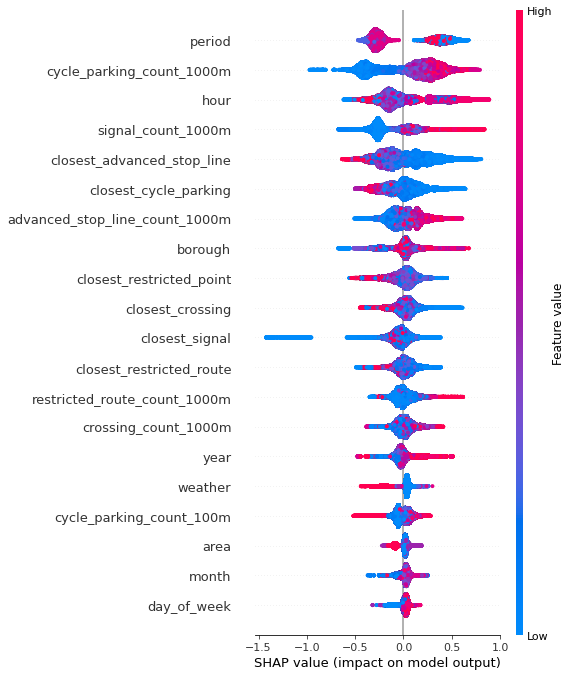

In [66]:
# Feature importance with infrastructure data 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)